## Malaria Cell Classification
The dataset contains a total of 27,558 cell images with equal instances of parasitized and uninfected cells. For more info: https://lhncbc.nlm.nih.gov/LHC-downloads/downloads.html#malaria-datasets

The dataset contains 2 folders

* Parasitized (Infected)
* Uninfected

In [1]:
from google.colab import files

uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [2]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria

 97% 657M/675M [00:04<00:00, 161MB/s]
100% 675M/675M [00:04<00:00, 144MB/s]


In [4]:
import zipfile

zip_ref = zipfile.ZipFile("/content/cell-images-for-detecting-malaria.zip")
zip_ref.extractall()
zip_ref.close()

In [27]:
# Importing important libraries

import numpy as np
from glob import glob
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential

In [6]:
import tensorflow as tf
print(tf.__version__)

2.12.0


## Preprocessing the data

In [10]:
para = !ls /content/cell_images/Parasitized
uninfected = !ls /content/cell_images/Uninfected

len(para), len(uninfected)

(13780, 13780)

In [12]:
# Creating empty folders

import os

!mkdir data
!mkdir data/train
!mkdir data/train/Infected
!mkdir data/train/Uninfected


!mkdir data/test
!mkdir data/test/Infected
!mkdir data/test/Uninfected


In [15]:
# Creating train and test dataset

import shutil

path = "/content/data/"

# Train dataset
for filename in os.listdir("/content/cell_images/Parasitized")[0:12780]:
    src_path = "/content/cell_images/Parasitized/" + filename
    dst_path = os.path.join(path, 'train/Infected/')
    shutil.move(src_path, dst_path)

for filename in os.listdir("/content/cell_images/Uninfected")[0:12780]:
    src_path = "/content/cell_images/Uninfected/" + filename
    dst_path = os.path.join(path, 'train/Uninfected/')
    shutil.move(src_path, dst_path)


# move rest of the files to the test directory
for filename in os.listdir("/content/cell_images/Parasitized"):
    src_path = "/content/cell_images/Parasitized/" + filename
    dst_path = os.path.join(path, 'test/Infected/')
    shutil.move(src_path, dst_path)

for filename in os.listdir("/content/cell_images/Uninfected"):
    src_path = '/content/cell_images/Uninfected/' + filename
    dst_path = os.path.join(path, 'test/Uninfected/')
    shutil.move(src_path, dst_path)

In [16]:
IMG_SIZE = [224,224]

train_dir = "/content/data/train"
test_dir = "/content/data/test"


In [21]:
import pathlib

data_dir = pathlib.Path(train_dir)

class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))

class_names, len(class_names)

(array(['Infected', 'Uninfected'], dtype='<U10'), 2)

In [51]:
# Preprocessing and augmenting the images

train_datagen = ImageDataGenerator(rescale=1./255,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)


train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224,224),
                                               batch_size=32,
                                               class_mode='categorical')

test_data = train_datagen.flow_from_directory(test_dir,
                                               target_size=(224,224),
                                               batch_size=32,
                                               class_mode='categorical')

Found 25559 images belonging to 2 classes.
Found 1999 images belonging to 2 classes.


In [52]:
vgg19 = VGG19(input_shape=IMG_SIZE + [3], weights='imagenet', include_top=False)

for layer in vgg19.layers:
  layer.trainable = False


model = Sequential([
    vgg19,
    Flatten(),
    Dense(len(class_names), activation='softmax')
])

In [53]:
model.compile(
  loss='categorical_crossentropy',
  optimizer=tf.keras.optimizers.Adam(),
  metrics=['accuracy']
)

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_7 (Flatten)         (None, 25088)             0         
                                                                 
 dense_6 (Dense)             (None, 2)                 50178     
                                                                 
Total params: 20,074,562
Trainable params: 50,178
Non-trainable params: 20,024,384
_________________________________________________________________


In [54]:
history = model.fit(train_data,
                    validation_data = test_data,
                    epochs=3,
                    steps_per_epoch=len(train_data),
                    validation_steps=len(test_data)
                    )

Epoch 1/3
799/799 [==============================] - 362s 451ms/step - loss: 0.3859 - accuracy: 0.8367 - val_loss: 0.3447 - val_accuracy: 0.8414
Epoch 2/3
799/799 [==============================] - 375s 469ms/step - loss: 0.2789 - accuracy: 0.8903 - val_loss: 0.2163 - val_accuracy: 0.9165
Epoch 3/3
799/799 [==============================] - 362s 453ms/step - loss: 0.2538 - accuracy: 0.9023 - val_loss: 0.2328 - val_accuracy: 0.9075


In [55]:
# Function for plotting loss curve

def loss_curve(history):

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label="Training_Loss")
  plt.plot(epochs, val_loss, label="Val_Loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="Training_Accuracy1")
  plt.plot(epochs, val_accuracy, label="Val_Accuracy")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

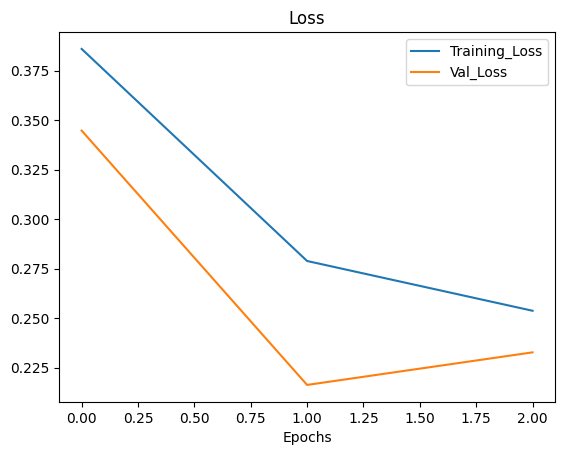

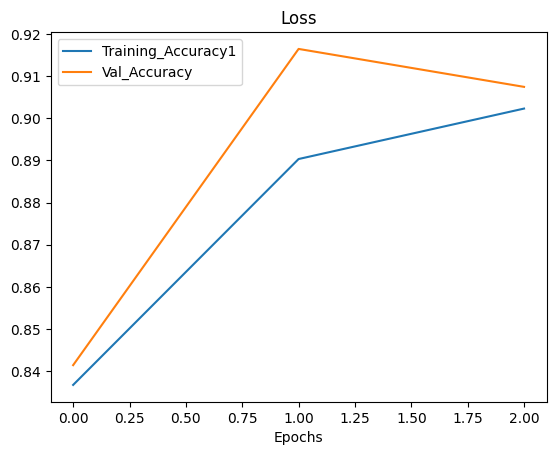

In [56]:
loss_curve(history)

In [57]:
preds = model.predict(test_data)
preds

63/63 [==============================] - 26s 413ms/step


array([[0.00173424, 0.9982658 ],
       [0.5489343 , 0.45106578],
       [0.40814003, 0.59186   ],
       ...,
       [0.01398843, 0.98601156],
       [0.01162104, 0.9883789 ],
       [0.03239395, 0.967606  ]], dtype=float32)

In [58]:
def preprocess_img_to_classname(model, filename, IMG_SHAPE=IMG_SIZE):
  '''
    This function decodes the images into tensors, resizes, rescales and
    get's the highest probablity from the tensor and that index will be matched
    with the className's index and that className is shown as prediction. Enter
    model_name, image_name and default img_shape=224.
  '''

  # Read image
  image = tf.io.read_file(filename)

  # Decode into tensors
  image = tf.image.decode_image(image)

  # Resize
  image = tf.image.resize(image, size=IMG_SIZE)

  # Rescale
  image = image/255.

  # Expanding dims
  image = tf.expand_dims(image, axis=0)

  # Prediction
  preds = model.predict(image)

  # ClassName
  name = class_names[tf.argmax(preds[0])]
  return name

In [59]:
# Making a Prediction on an Uninfected Cell image.

preprocess_img_to_classname(model, '/content/cell_images/cell_images/Uninfected/C100P61ThinF_IMG_20150918_144823_cell_34.png')

1/1 [==============================] - 0s 159ms/step


'Uninfected'

In [60]:
# Saving the model

model.save('model_vgg19.h5')